In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osgeo.gdal
from rasterstats import zonal_stats
import rioxarray as rxr
import rasterio as rio
from affine import Affine

import matplotlib.pyplot as plt
import contextily as ctx

In [30]:
heat_gdf = gpd.read_file('data/Mesonet/daily_temp.gpkg', layer='temps')
heat_gdf['date_time'] = pd.to_datetime(heat_gdf['date_time'])
district_gdf = gpd.read_file('data/Fire_Districts/Fire_Districts.shp')

In [31]:
heat_gdf.head()

,date_time,stid,relative_humidity_high,air_temp_high,heat_index_high,relative_humidity_low,air_temp_low,heat_index_low,lon,lat,geometry
0,2018-01-01,KBUR,100.00,73.94,72.12299,22.35,44.6,42.07209,-118.36538,34.19967,POINT (-118.36538 34.19967)
1,2018-01-02,KBUR,82.14,80.96,79.29248,12.73,51.8,49.59400,-118.36538,34.19967,POINT (-118.36538 34.19967)
2,2018-01-03,KBUR,52.30,75.20,74.11247,16.05,53.6,50.30359,-118.36538,34.19967,POINT (-118.36538 34.19967)
3,2018-01-04,KBUR,50.37,75.20,74.23091,18.57,51.8,49.03376,-118.36538,34.19967,POINT (-118.36538 34.19967)
4,2018-01-05,KBUR,93.65,73.40,73.11665,40.92,53.6,52.77579,-118.36538,34.19967,POINT (-118.36538 34.19967)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

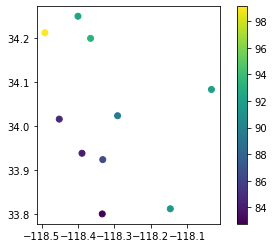

In [32]:
heat_gdf[heat_gdf['date_time']=='2018-08-01'].plot(column='heat_index_high', legend=True, zorder=5)
heat_gdf.crs

In [33]:
bounds = district_gdf.total_bounds

heat_gdf['date_time'] = heat_gdf['date_time'].astype(str) #avoids shapefile error with processing datetime types
heat_gdf[heat_gdf['date_time']=='2018-08-01'].to_file('data/working/temp_data.shp')

/Users/seth/anaconda3/envs/cemo/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
<ipython-input-33-27874fe77c20>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  heat_gdf[heat_gdf['date_time']=='2018-08-01'].to_file('data/working/temp_data.shp')


In [34]:
rasterDs = osgeo.gdal.Grid('data/working/raster.tiff',
                           'data/working/temp_data.shp',
                           format='GTiff',
                           zfield='heat_index',
                           outputBounds=bounds,
                           algorithm='invdist',
                           )

In [35]:
rasterDs = None
del rasterDs

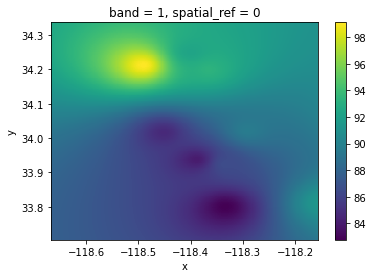

In [37]:
raster.plot()

In [28]:
data=rio.open('data/working/raster.tiff')
af = Affine(0.002003195255464829, 0.0, -118.66818799560865,
       0.0, -0.002475198135987511, 34.33730781636643)

In [29]:
data.transform

Affine(0.002003195255464829, 0.0, -118.66818799560865,
       0.0, -0.002475198135987511, 34.33730781636643)

In [21]:
stats = pd.DataFrame(zonal_stats(district_gdf, data.read(1), affine=af, stats=['mean']))
new_gdf = district_gdf.join(stats)
new_gdf.head()

,ObjectID,TOOLTIP,Battalion,Division,District,Battalion_,District_N,geometry,mean
0,1,Fire Battalion: 18\nFire Division: South Divis...,18,South Division,58,Battalion 18,District 58,"POLYGON ((-118.36743 34.06034, -118.36881 34.0...",86.070606
1,2,Fire Battalion: 9\nFire Division: North Divisi...,9,North Division,23,Battalion 9,District 23,"POLYGON ((-118.53778 34.11104, -118.53769 34.0...",87.259427
2,3,Fire Battalion: 2\nFire Division: South Divisi...,2,South Division,47,Battalion 2,District 47,"POLYGON ((-118.16056 34.08369, -118.16141 34.0...",88.764684
3,4,Fire Battalion: 2\nFire Division: South Divisi...,2,South Division,55,Battalion 2,District 55,"POLYGON ((-118.23008 34.13561, -118.23005 34.1...",88.090155
4,5,Fire Battalion: 4\nFire Division: South Divisi...,4,South Division,62,Battalion 4,District 62,"MULTIPOLYGON (((-118.43229 34.02398, -118.4290...",85.279641


<Axes: >

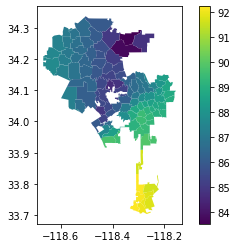

In [22]:
new_gdf.plot(column='mean', legend=True)

In [37]:
with rio.open('data/working/raster.tiff') as src:
    # Read the raster data as an array
    raster_array = src.read(1)
    
    # Flip the array vertically
    flipped_array = np.flip(raster_array, axis=0)
    
    # Update the metadata of the raster
    kwargs = src.meta.copy()
    
    # Write the flipped raster to a new file
    with rio.open('data/working/raster.tiff', 'w', **kwargs) as dst:
        dst.write(flipped_array, 1)
        dst.transform = af

#with rio.open('data/working/raster.tiff') as src:
   # transform = src.transform
 #   transform = transform * Affine(1,0,1,0,-1,1)
    
   # with rio.open('data/working/raster.tiff', 'w', **src.profile) as dst:
   #     dst.write(src.read())
  #      dst.transform = af

In [40]:
data = rio.open('data/working/raster.tiff')
data.transform

Affine(0.002003195255464829, 0.0, -118.66818799560865,
       0.0, -0.002475198135987511, 34.33730781636643)

In [38]:
zonal_stats('data/Fire_Districts/Fire_Districts.shp', data.read(1), affine=af)

[{'min': 85.52785789860991,
  'max': 86.6753367505825,
  'mean': 86.07060627636291,
  'count': 176},
 {'min': 86.80895751250192,
  'max': 87.81284052862621,
  'mean': 87.25942680486523,
  'count': 590},
 {'min': 88.45150183007095,
  'max': 89.1024180777829,
  'mean': 88.7646840496473,
  'count': 176},
 {'min': 87.64351690630508,
  'max': 88.49304993632674,
  'mean': 88.0901550613723,
  'count': 148},
 {'min': 84.68519398243231,
  'max': 86.14207144443965,
  'mean': 85.27964114214467,
  'count': 150},
 {'min': 85.58972403846018,
  'max': 86.12054481675317,
  'mean': 85.8828095309464,
  'count': 302},
 {'min': 84.88380255360056,
  'max': 85.67487753582601,
  'mean': 85.38479646557272,
  'count': 252},
 {'min': 86.50125607183038,
  'max': 86.96029445412944,
  'mean': 86.7530766222641,
  'count': 226},
 {'min': 89.70275625122397,
  'max': 89.84809615350974,
  'mean': 89.76108382336622,
  'count': 10},
 {'min': 88.86228407640445,
  'max': 91.14879641671565,
  'mean': 89.70533838826576,
  'c

<Axes: >

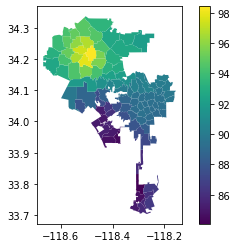

In [41]:
stats = pd.DataFrame(zonal_stats(district_gdf, data.read(1), affine=af, stats=['mean']))
#stats.head()
new_gdf = district_gdf.join(stats)
new_gdf.plot(column='mean', legend=True)